In [1]:
import numpy as np
import rosbag
import bagpy
import yaml
from bagpy import bagreader
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib as mpl
import datetime
import time
from tf.transformations import euler_from_quaternion, quaternion_from_euler

In [2]:
from importlib.metadata import version
version('matplotlib')

'3.7.1'

\begin{array}{|l|l|l|}
\hline ID & Test name & Description \\
\hline 1 & \terowt { Firowed (0.0) } & \terowt { Top wheel 0, Yaw target 0 } \\
\hline 2 & \terowt { Firowed (0.0) } & \terowt { Top wheel 0, Yaw target 0 } \\
\hline 3 & \terowt { Firowed (6.0) } & \text { Top wheel 6, Yaw target 0 } \\
\hline 4 & \text { Fixed (-6.0) } & \text { Top wheel -6, Yaw target 0 } \\
\hline 5 & \text { Fixed (9.0) } & \text { Top wheel 9, Yaw target 0 } \\
\hline 6 & \text { Fixed (-9.0) } & \text { Top wheel -9, Yaw target 0 } \\
\hline 7 & \text { Fixed (0.5) } & \text { Top wheel 0, Yaw target 3 } \\
\hline 8 & \text { Fixed (0.-5) } & \text { Top wheel 0, Yaw target -3 } \\
\hline 9 & \text { Fixed (-6.-5) } & \text { Top wheel -6, Yaw target -3 } \\
\hline
\end{array}

All tests are done with constant X-velocity: 0.05 m/s

In [3]:
# Load experiment data
bag = bagreader('nav_tests_2023-05-28-14-07-38.bag')

[INFO]  Data folder nav_tests_2023-05-28-14-07-38 already exists. Not creating.


In [4]:
odom_p = bag.message_by_topic('rr_robot/odom')

feedback_p = bag.message_by_topic('move_base/feedback')
goal_p = bag.message_by_topic('move_base/goal')


odom = pd.read_csv(odom_p)
feedback = pd.read_csv(feedback_p)
goal = pd.read_csv(goal_p)

In [5]:
def extract_poses(topic, bag='nav_tests_2023-05-28-14-07-38.bag'):
    paths = []
    for topic, msg, t in rosbag.Bag(bag).read_messages(topic): 
        poses = []
        for pose in msg.poses:
            angle = euler_from_quaternion([pose.pose.orientation.x, pose.pose.orientation.y, pose.pose.orientation.z, pose.pose.orientation.w])[-1]
            poses.append([pose.pose.position.x, pose.pose.position.y, angle])
        paths.append([msg.header.stamp.to_time(), pd.DataFrame(poses, columns=["x", "y", "yaw"])])
    return pd.DataFrame(paths, columns=["Time", "paths"])

In [6]:
global_plans = extract_poses('/move_base/TebLocalPlannerROS/global_plan').drop_duplicates("Time")
local_plans = extract_poses('/move_base/TebLocalPlannerROS/local_plan')

In [7]:
odom["Angles"] = [euler_from_quaternion(
                    [odom["pose.pose.orientation.x"][id], odom["pose.pose.orientation.y"][id], odom["pose.pose.orientation.z"][id], odom["pose.pose.orientation.w"][id]])[-1] for id in odom.index]

In [8]:
dfs = [odom, global_plans, local_plans]
tests = []
prev = float("inf")
for t in goal["Time"][-1::-1]:
    x = []
    for df in dfs:
        x.append(df[(df["Time"] >= t) & (df["Time"] < prev)])
    tests.append(x)
    prev = t

In [9]:
# angles_kin = [euler_from_quaternion(
# [df_odom_kin["pose.pose.orientation.x"][id], df_odom_kin["pose.pose.orientation.y"][id], df_odom_kin["pose.pose.orientation.z"][id], df_odom_kin["pose.pose.orientation.w"][id]])[-1] for id in df_odom_kin.index]

In [10]:
# angles_true = [euler_from_quaternion(
# [df_odom_true["pose.pose.orientation.x"][id], df_odom_true["pose.pose.orientation.y"][id], df_odom_true["pose.pose.orientation.z"][id], df_odom_true["pose.pose.orientation.w"][id]])[-1] for id in df_odom_true.index]

In [11]:
# df_odom_kin["Angles"] = angles_kin
# df_odom_true["Angles"] = angles_true

In [12]:
headers = ["pose.pose.position.x", "pose.pose.position.y", "Angles", "twist.twist.linear.x", "twist.twist.linear.y", "twist.twist.angular.z"]
labels = ["x-position [m]", "y-position [m]", "yaw-angle [rad]", r"x-velocity [$\frac{m}{s}$]", r"y-velocity [$\frac{m}{s}$]", r"angular-velocity [$\frac{rad}{s}$]"]

In [13]:
def TrimToStart(df, tstart):
    df.drop(df[df["Time"]<tstart].index, inplace=True)
    df.Time -= tstart

def CalibrateZero(df):
    for col in headers:
        df[col] =  df[col] - df[col][df[col].index[0]]

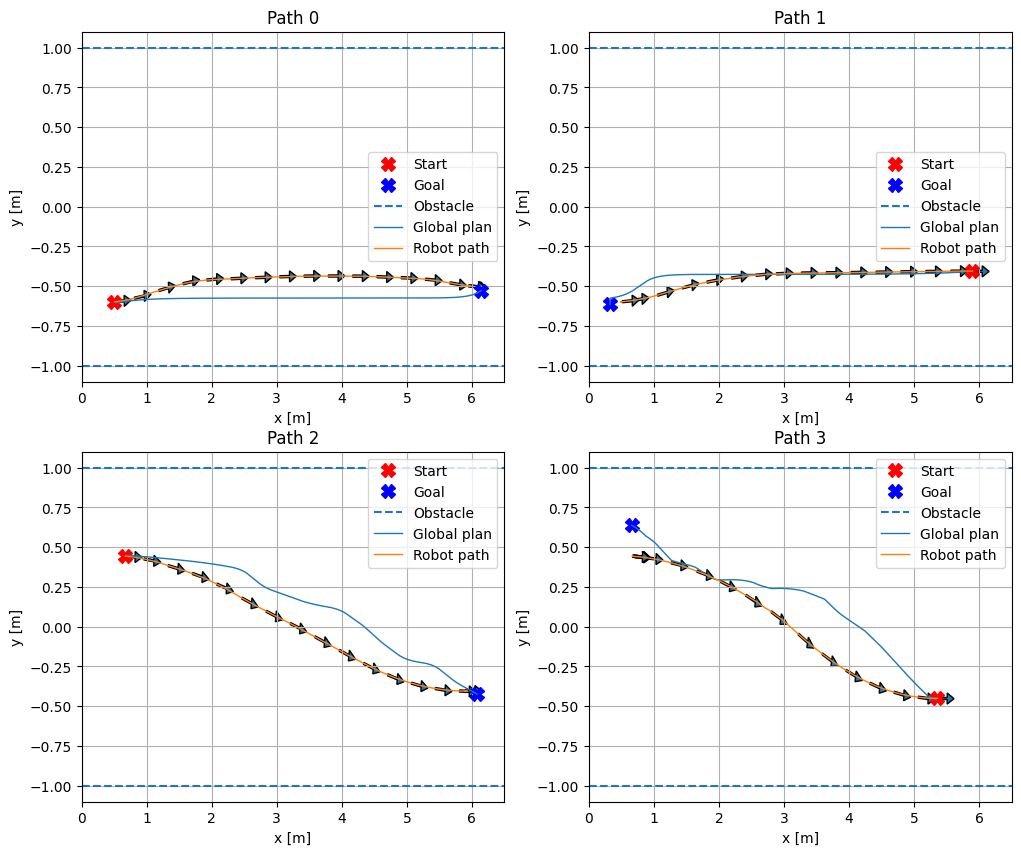

In [14]:
FP_WIDTH = 1.152
FP_HEIGHT = 0.342
ntests = len(tests)
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
axs = axs.reshape(-1)

for test, ax, i in zip(tests, axs,range(len(axs))):
    ax.set_title(f"Path {i}")
    ax.plot(test[1].paths.iloc[0].x.iloc[0], test[1].paths.iloc[0].y.iloc[0], "rX", label="Start", markersize=10)
    ax.plot(test[1].paths.iloc[0].x.iloc[-1], test[1].paths.iloc[0].y.iloc[-1], "bX", label="Goal", markersize=10)
    ax.axhline(y=-1, linestyle="--", label="Obstacle")
    ax.autoscale("True")
    test[1].paths.iloc[0].plot(x='x', xlabel='x [m]', y="y", ylabel="y [m]", grid=True, label="Global plan", ax=ax, linewidth=1)
    # for path in test[2].paths.iloc[::15]:
    #     path.plot(x='x', xlabel='x [m]', y="y", ylabel="y [m]", grid=True, legend=False, ax=ax, linewidth=1.5)
    #     ax.plot(path.x.iloc[0], path.y.iloc[0], "rP", markersize=10)
    #     ax.plot(path.x.iloc[-1], path.y.iloc[-1], "bP", markersize=10)
    first = True
    label="Robot pose"
    for x,y,yaw in zip(test[0]["pose.pose.position.x"][::70], test[0]["pose.pose.position.y"][::70], test[0]["Angles"][::70]):
        ax.arrow(x, y, np.cos(yaw)*0.15, np.sin(yaw)*0.15, width=0.013, head_width=0.07)
        # rect = Rectangle((x-FP_WIDTH/2, y-FP_HEIGHT/2), FP_WIDTH, FP_HEIGHT, angle=yaw*180/np.pi, rotation_point='center', fc='none', ec="black", linewidth=0.5, label=label)
        # ax.add_patch(rect)
        label=""
    ax.set_ylim(-1.1, 1.1)
    ax.set_xlim(0, 6.5)
    ax.plot(test[0]["pose.pose.position.x"], test[0]["pose.pose.position.y"], label="Robot path", linewidth=1)
    ax.axhline(y=1, linestyle="--")
    ax.legend()

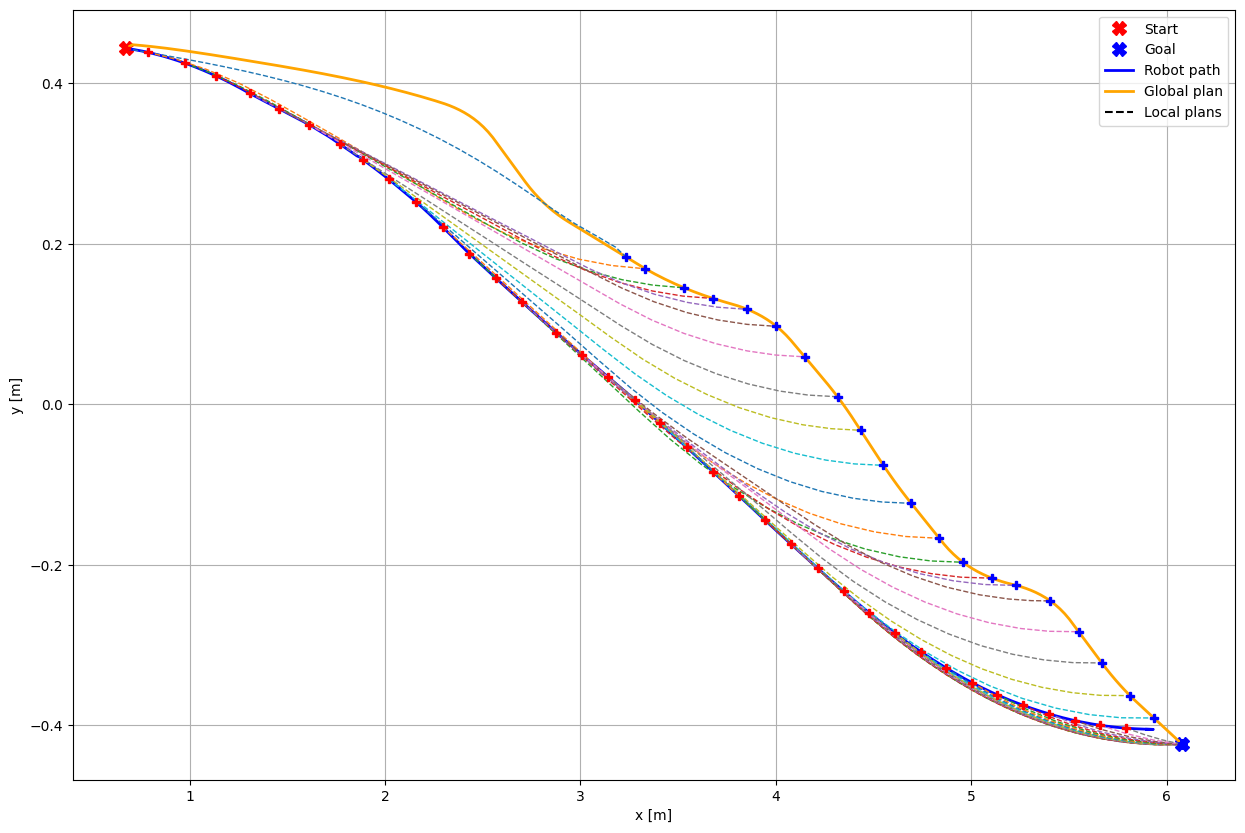

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
test = tests[2]

ax.autoscale("True")
ax.plot(test[1].paths.iloc[0].x.iloc[0], test[1].paths.iloc[0].y.iloc[0], "rX", label="Start", markersize=10)
ax.plot(test[1].paths.iloc[0].x.iloc[-1], test[1].paths.iloc[0].y.iloc[-1], "bX", label="Goal", markersize=10)
ax.plot(test[0]["pose.pose.position.x"], test[0]["pose.pose.position.y"], label="Robot path", linewidth=2, color="blue")
test[1].paths.iloc[0].plot(x='x', xlabel='x [m]', y="y", ylabel="y [m]", grid=True, label="Global plan", ax=ax, linewidth=2, color="orange")
ax.plot([], [], color="black", linestyle="--", label="Local plans")
for path in test[2].paths.iloc[::5]:
    artist = path.plot(x='x', xlabel='x [m]', y="y", ylabel="y [m]", grid=True, label="", ax=ax, linewidth=1, linestyle="--")
    ax.plot(path.x.iloc[0], path.y.iloc[0], "rP", markersize=6)
    ax.plot(path.x.iloc[-1], path.y.iloc[-1], "bP", markersize=6)
ax.legend()

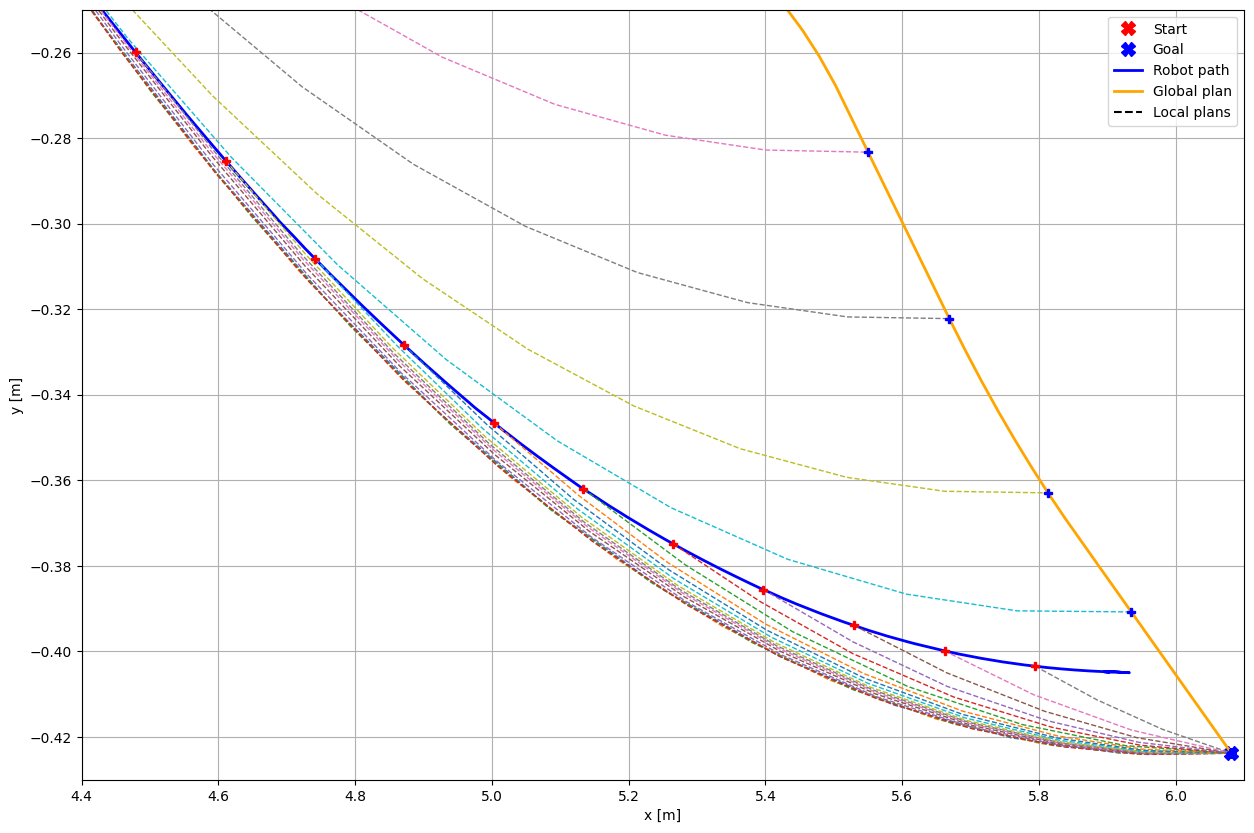

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
test = tests[2]

ax.plot(test[1].paths.iloc[0].x.iloc[0], test[1].paths.iloc[0].y.iloc[0], "rX", label="Start", markersize=10)
ax.plot(test[1].paths.iloc[0].x.iloc[-1], test[1].paths.iloc[0].y.iloc[-1], "bX", label="Goal", markersize=10)
ax.plot(test[0]["pose.pose.position.x"], test[0]["pose.pose.position.y"], label="Robot path", linewidth=2, color="blue")
ax.set_xlim((4.4, 6.1))
ax.set_ylim((-0.43, -0.25))
test[1].paths.iloc[0].plot(x='x', xlabel='x [m]', y="y", ylabel="y [m]", grid=True, label="Global plan", ax=ax, linewidth=2, color="orange")
ax.plot([], [], color="black", linestyle="--", label="Local plans")
for path in test[2].paths.iloc[::5]:
    artist = path.plot(x='x', xlabel='x [m]', y="y", ylabel="y [m]", grid=True, label="", ax=ax, linewidth=1, linestyle="--")
    ax.plot(path.x.iloc[0], path.y.iloc[0], "rP", markersize=6)
    ax.plot(path.x.iloc[-1], path.y.iloc[-1], "bP", markersize=6)
ax.legend()

KeyError: 'pose.pose.position.x'

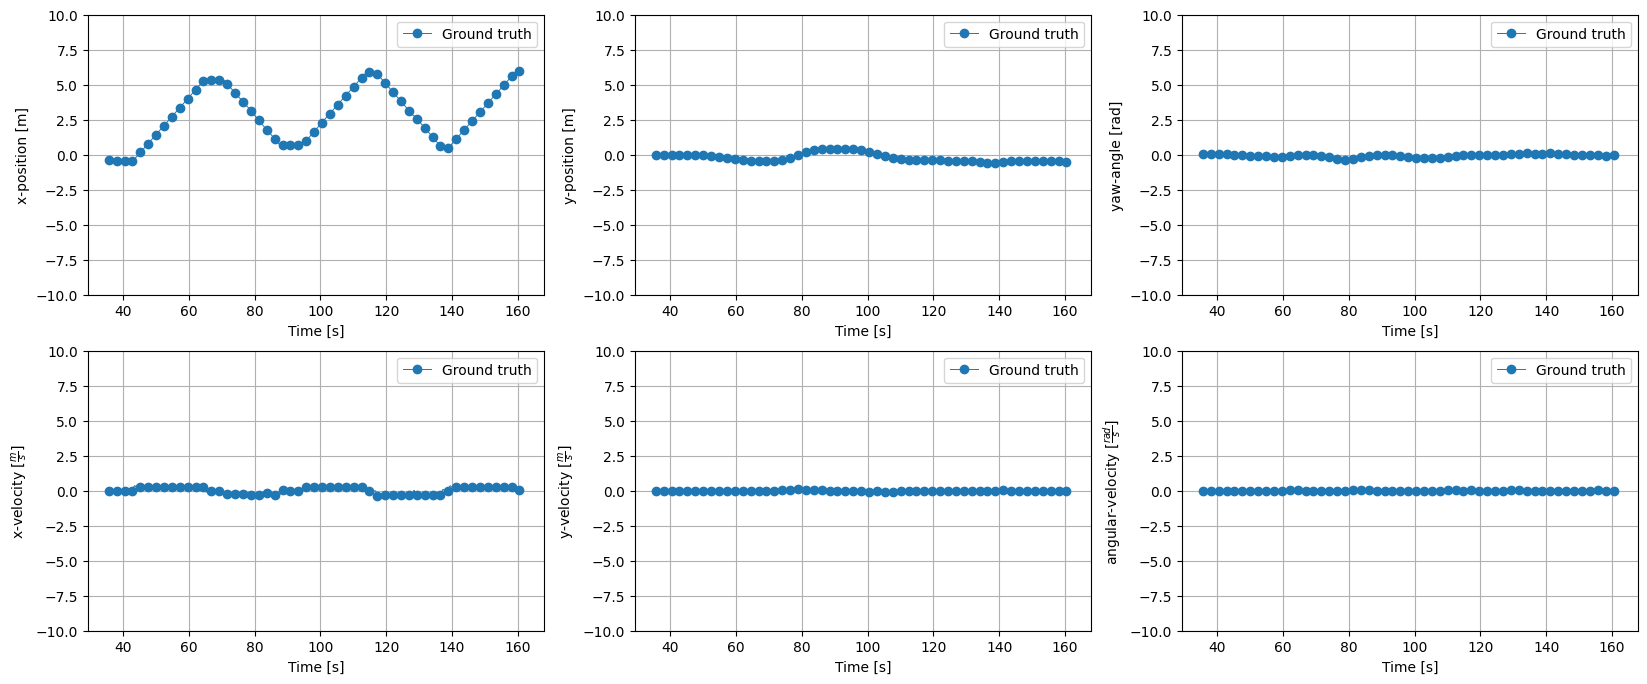

In [17]:
markers = ["o-", "P-", "^-"]
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20,8))
axs = axs.reshape(-1)

for df, name, marker, every in zip(dfs, ["Ground truth", "Kin odom", "Imu odom"], markers, [120, 120, 120]):
    for (header, label), ax in zip(zip(headers,labels), axs):
        df.plot(ylim=[-10, 10], x='Time', xlabel='Time [s]', y=header, ylabel=label, grid=True, legend=True, ax=ax, label=name, linewidth=0.7, marker=marker[0], linestyle=marker[1], markevery=every)
for ax in axs:
    ax.autoscale(True)


In [ ]:
# contact.data = contact.data.replace({True: 1, False: 0})
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,8))

# contact.plot(ylim=[-10, 10], x='Time', xlabel='Time [s]', y="data", ylabel="Is contacting", grid=True, legend=False, ax=ax)
# ax.autoscale(True)
